 ---

In this notebook, we will learn how to write our own convolutional neural networks on the PyTorch framework, and test their work on the MNIST and CIFAR10 datasets.

** ATTENTION: ** Considered *** task of image classification ***.

(It is assumed that the reader is already familiar with a multilayer neural network.)

*** Convolutional Neural Network (CNN) *** is a multilayer neural network that has in its architecture, in addition to * fully connected layers * (and sometimes they may not exist), ** Conv Layers ** and ** pooling-layers (Pool Layers) **.

Actually, these networks got this name because their operation is based on the ** convolution ** operation.


It should be said right away that convolutional neural networks ** were invented primarily for tasks related to pictures **, therefore, they also "expect" a picture at the input.

Let's consider their device in more detail:

* This is what a shallow convolutional neural network looks like with the following architecture:
ʻInput -> Conv 5x5 -> Pool 2x2 -> Conv 5x5 -> Pool 2x2 -> FC -> Output`

<Img src = "https://camo.githubusercontent.com/269e3903f62eb2c4d13ac4c9ab979510010f8968/68747470733a2f2f7261772e6769746875622e636f6d2f746176677265656e2f6c616e647573655f636c617373696669636174696f6e2f6d61737465722f66696c652f636e6e2e706e673f7261773d74727565" width = 800, height = 600>

Convolutional neural networks (ordinary, there are also much more advanced ones) are almost always built according to the following rule:

ʻINPUT -> [[CONV -> RELU] * N -> POOL?] * M -> [FC -> RELU] * K -> FC`

i.e:

1). *** Input layer *** (batch images `HxWxC`)

2). $ M $ blocks (M $ \ ge $ 0) from convolutions and poolings, and in exactly the same order as in the formula above. All these $ M $ blocks together are called the *** feature extractor *** of the convolutional neural network, because this part of the network is directly responsible for the formation of new, more complex features on top of those that are supplied (that is, by analogy with MLP, we again we move on to a new feature space, but here it is built more difficult than in conventional multilayer networks, since the convolution operation is used)

3). $ K $ pieces of FullyConnected layers (with activations). This part of the $ K $ FC layers is called *** classificator ***, since these layers are directly responsible for predicting the class needs (now we are considering the problem of image classification).

<h3 style = "text-align: center;"> <b> Convolutional neural network on PyTorch </b> </h3>

Let us recall the main components of a neural network once again:

- directly, the ** architecture ** of the neural network itself (this includes the types of activation functions for each neuron);
- initial ** initialization ** of the weights of each layer;
- method ** optimization ** of a neural network (this also includes a method for changing the `learning_rate`);
- size of ** batches ** (`batch_size`);
- the number of training iterations (`num_epochs`);
- ** loss function ** (`loss`);
- type of ** regularization ** of a neural network (you can have your own for each layer);

Something related to *** data and task ***:
- the very ** quality ** of the sample (consistency, purity, correctness of the problem statement);
- ** sample size **;

Since we are now considering ** the CNN architecture **, in addition to these components, the following things can be configured in the convolutional neural network:

- (in each ConvLayer) ** filter size (fold window) ** (`kernel_size`)
- (in each ConvLayer) ** number of filters ** (ʻout_channels`)
- (in each ConvLayer) ** stride size (stride) ** (`stride`)
- (in each ConvLayer) ** padding type ** (`padding`)


- (in each PoolLayer) ** pooling window size ** (`kernel_size`)
- (in each PoolLayer) ** pooling window step ** (`stride`)
- (in each PoolLayer) ** pooling type ** (`pool_type`)
- (in each PoolLayer) ** padding type ** (`padding`)

What they are usually taken will be shown in the example below. At least you can start with these settings to understand what quality "out of the box" a simple model will have.

Let's see how CNN works on MNIST and CIFAR.

In [179]:
import torch
import torchvision
from torchvision import transforms
from torchsummary import summary
import keras
from torch.utils.data import DataLoader,Dataset
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt  # для отрисовки картиночек
%matplotlib inline

<img src="http://present5.com/presentation/20143288_415358496/image-8.jpg" width=500, height=400>

** MNIST: ** This is a set of 70k pictures of handwritten numbers from 0 to 9 written by humans, 60k of which are a training dataset (`train` dataset)), and another 10k are allocated for model testing (` test` dataset).

Download and upload to the loader:

** Pay attention to the `batch_size` argument: ** it will be responsible for the size of the batch that will be supplied when optimizing the neural network

In [180]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

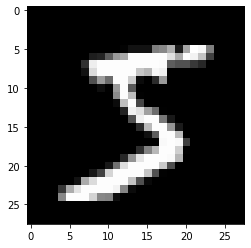

In [181]:
plt.imshow(x_train[0], cmap='gray')

Сами данные лежат в полях `trainloader.dataset.train_data` и `testloader.dataset.test_data`:

In [182]:
x_train.shape

(60000, 28, 28)

In [183]:
x_test.shape

(10000, 28, 28)

Display the first image:

In [184]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

Отрисовка заданной цифры:

In [185]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [191]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = MyDataset(x_train,y_train, transform=transform)
trainloader = DataLoader(dataset, batch_size=5)

testset = MyDataset(x_test,y_test, transform=transform)
testloader = DataLoader(dataset, batch_size=5)

Как итерироваться по данным с помощью `loader'`а? Очень просто:

In [187]:
for data in trainloader:
    print(data)
    break

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
   

То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 4), причём в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Теперь вернёмся к тому, что в PyTorch есть две "парадигмы" построения нейросетей -- `Functional` и `Seuquential`. Со второй мы уже хорошенько разобрались в предыдущих ноутбуках по нейросетям, теперь мы испольузем именно `Functional` парадигму, потому что при построении свёрточных сетей это намного удобнее:

In [188]:
import torch.nn as nn
import torch.nn.functional as F  # Functional

In [194]:
# ЗАМЕТЬТЕ: КЛАСС НАСЛЕДУЕТСЯ ОТ nn.Module
class SimpleConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super(SimpleConvNet, self).__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(4 * 4 * 16, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 4 * 4 * 16)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [195]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

net = SimpleConvNet()#.to(device)

batch = []



batch = next(iter(trainloader))

net.forward(torch.FloatTensor(batch[0]))

tensor([[ 0.1040, -0.0646, -0.0874, -0.0675,  0.0572,  0.0249,  0.0704, -0.0052,
          0.0876,  0.0445],
        [ 0.1135, -0.0686, -0.0819, -0.0680,  0.0587,  0.0277,  0.0695, -0.0024,
          0.0939,  0.0403],
        [ 0.1074, -0.0668, -0.0907, -0.0647,  0.0558,  0.0241,  0.0654, -0.0103,
          0.0831,  0.0425],
        [ 0.1002, -0.0704, -0.0839, -0.0609,  0.0528,  0.0203,  0.0707, -0.0108,
          0.0789,  0.0530],
        [ 0.1079, -0.0640, -0.0898, -0.0650,  0.0575,  0.0232,  0.0692, -0.0062,
          0.0792,  0.0467]], grad_fn=<AddmmBackward>)

In [196]:
summary(net.cuda(), (1,28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


**Важное примечание:** Вы можете заметить, что в строчках с `#!!!` есть не очень понятный сходу 4 `*` 4 `*` 16. Это -- размерность картинки перед FC-слоями (H x W x C), тут её приходиться высчитывать вручную (в Keras, например, `.Flatten()` всё делает за Вас). Однако есть один *лайфхак* -- просто сделайте в `forward()` `print(x.shape)` (закомментированная строка). Вы увидите размер `(batch_size, C, H, W)` -- нужно перемножить все, кроме первого (batch_size), это и будет первая размерность `Linear()`, и именно в C * H * W нужно "развернуть" x перед подачей в `Linear()`.  

То есть нужно будет запустить цикл с обучением первый раз с `print()` и сделать после него `break`, посчитать размер, вписать его в нужные места и стереть `print()` и `break`.

Код обучения слоя:

In [197]:
from tqdm import tqdm_notebook

In [198]:
# объявляем сеть
net = SimpleConvNet()

In [199]:
# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
losses = []

In [200]:
cnt = 0
temp = 0
for i, batch in enumerate(tqdm_notebook(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        cnt = i
        if i % 2000 == 1999:
            temp += 1 
cnt,temp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


(11999, 6)

 17%|█▋        | 2029/12000 [00:07<00:37, 263.11it/s]

[1,  2000] loss: 0.885



 34%|███▎      | 4046/12000 [00:15<00:30, 262.05it/s]

[1,  4000] loss: 0.322



 50%|█████     | 6046/12000 [00:22<00:22, 263.07it/s]

[1,  6000] loss: 0.252



 67%|██████▋   | 8041/12000 [00:29<00:14, 265.44it/s]

[1,  8000] loss: 0.206



 84%|████████▎ | 10035/12000 [00:37<00:07, 267.20it/s]

[1, 10000] loss: 0.186



100%|██████████| 12000/12000 [00:44<00:00, 267.63it/s]


[1, 12000] loss: 0.139


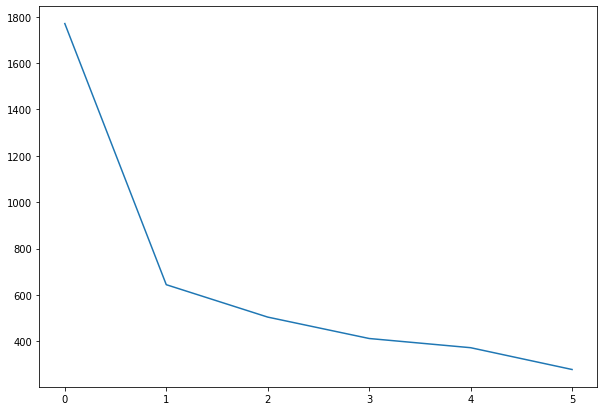

 17%|█▋        | 2042/12000 [00:07<00:38, 256.05it/s]

[2,  2000] loss: 0.136



 34%|███▍      | 4053/12000 [00:15<00:30, 260.11it/s]

[2,  4000] loss: 0.122



 50%|█████     | 6043/12000 [00:23<00:23, 254.26it/s]

[2,  6000] loss: 0.112



 67%|██████▋   | 8038/12000 [00:31<00:15, 260.89it/s]

[2,  8000] loss: 0.107



 84%|████████▎ | 10026/12000 [00:38<00:07, 256.96it/s]

[2, 10000] loss: 0.112



100%|██████████| 12000/12000 [00:46<00:00, 258.61it/s]


[2, 12000] loss: 0.087


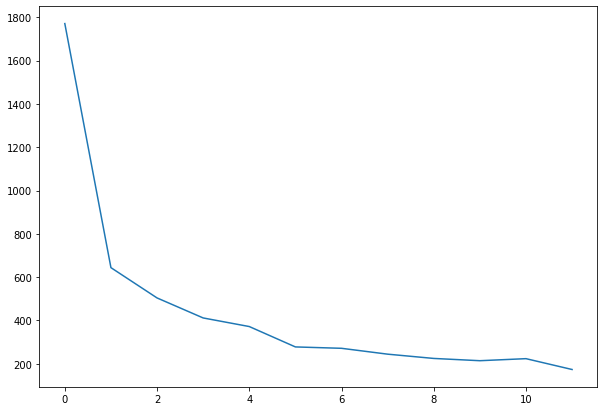

100%|██████████| 2/2 [01:31<00:00, 45.48s/it]

In [ ]:
from tqdm import tqdm
# итерируемся
for epoch in tqdm(range(2)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm(trainloader)):
        # так получаем текущий батч
        X_batch, y_batch = batch
        
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выведем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            losses.append(running_loss)
            running_loss = 0.0

    plt.figure(figsize=(10,7))
    plt.plot(np.arange(len(losses)), losses)
    plt.show()

print('Обучение закончено')

Протестируем на всём тестовом датасете, используя метрику accuracy_score:

In [ ]:
class_correct = list(0. for i in range(10))
class_incorrect = list()
class_total = list(0. for i in range(10))
classes = list([i for i in range(10)])
with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)
        _, predicted = torch.max(y_pred, 1)
#         print(labels)
#         print(predicted)
        c = (predicted == labels)
#         print(c)
        break
        for i in range(5):
            label = labels[i]
#             print(label)
#             break
#         break
            if c[i].item():
                class_correct[label] += c[i].item()
                class_total[label] += 1
            else:
                class_incorrect.append([predicted[i].item(), labels[i].item()])
                
print(class_incorrect)
# for i in range(10):
#     print('Accuracy of %5s : %2d %%' % (
#         classes[i], 100 * class_correct[i] / class_total[i]))

### Задача 1

Написать код, который выводит те примеры где классификатор ошибся. Проанализировать ошибки и предложить улучшения (в виде research report, google it) классификатор для того чтобы поднять его качество.

### Show failures
Initially, there were problems with `net.cuda()`, probobly because of devices cuda drivers are too old for pytorch to recognized. The problem was solved by removing `cuda()` part and using cpu instead.
After, shapes of `labels` and `predicted` tensors were checked as well as tensor `c` to determine how they worked. 
If predicted tensor is [5,0,4,1,9] and labels tensor is [5,9,4,1,9] then tencor `c` will be [True, False, True, True, True]. Thus, it was determined that to show the incorrect results, it is requred to create an array of wrong answers to which tuples of predicted number and actual number will be appended. All left is to print `class_incorrect`.

---

### Задача 2

Протестируйте эту нейросеть на отдельных картинках из тестового датасета: напишите функцию, которая принимает индекс картинки в тестовом датасете, отрисовывает её, потом запускает на ней модель (нейросеть) и выводит результат предсказания.

---

<h3 style="text-align: center;"><b>CIFAR10</b></h3>

<img src="https://raw.githubusercontent.com/soumith/ex/gh-pages/assets/cifar10.png" width=500, height=400>

**CIFAR10:** это набор из 60k картинок 32х32х3, 50k которых составляют обучающую выборку, и оставшиеся 10k - тестовую. Классов в этом датасете 10: `'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'`.

Скачаем и загрузим в `loader`'ы:

**Обратите внимание на аргумент `batch_size`:** именно он будет отвечать за размер батча, который будет подаваться при оптимизации нейросети

In [112]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.Grayscale(num_output_channels=1),
    #  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        #  std=[0.229, 0.224, 0.225] )])
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [113]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

RuntimeError: ignored

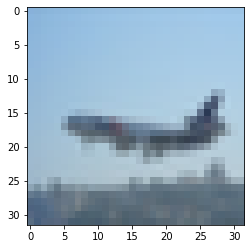

In [114]:
# import cv2
# случайный индекс от 0 до размера тренировочной выборки
i = np.random.randint(low=0, high=50000)

plt.imshow(trainloader.dataset.data[i], cmap='gray');
image = trainloader.dataset.data[i]
image.shape
y_pred = net(torch.Tensor(trainloader.dataset.data[i]))
print(y_pred)

То есть мы имеем дело с кусочками данных размера batch_size (в данном случае = 4), причём в каждом батче есть как объекты, так и ответы на них (то есть и $X$, и $y$).

Данные готовы, мы даже на них посмотрели.

К делу:

### Задача 3

Напишите свою свёрточную нейросеть для предсказания на CIFAR10.

In [115]:
next(iter(trainloader))[0].shape

torch.Size([4, 3, 32, 32])

In [116]:
class MyConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super().__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        # Напишите свой код тут
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        #еапишите свой код тут
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Обучим:

In [120]:
# пример взят из официального туториала: 
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

net = MyConvNet()

loss_fn = torch.nn.CrossEntropyLoss()
losses = []

learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

# итерируемся
for epoch in tqdm_notebook(range(10)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # напишите свой код тут
        X_batch, y_batch = batch
        
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выводем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


[1,  2000] loss: 2.051
[1,  4000] loss: 1.842
[1,  6000] loss: 1.758
[1,  8000] loss: 1.674
[1, 10000] loss: 1.615
[1, 12000] loss: 1.580



[2,  2000] loss: 1.546
[2,  4000] loss: 1.521
[2,  6000] loss: 1.502
[2,  8000] loss: 1.479
[2, 10000] loss: 1.432
[2, 12000] loss: 1.458



[3,  2000] loss: 1.418
[3,  4000] loss: 1.407
[3,  6000] loss: 1.389
[3,  8000] loss: 1.379
[3, 10000] loss: 1.381
[3, 12000] loss: 1.349



[4,  2000] loss: 1.336
[4,  4000] loss: 1.318
[4,  6000] loss: 1.330
[4,  8000] loss: 1.292
[4, 10000] loss: 1.300
[4, 12000] loss: 1.286



[5,  2000] loss: 1.285
[5,  4000] loss: 1.269
[5,  6000] loss: 1.251
[5,  8000] loss: 1.252
[5, 10000] loss: 1.239
[5, 12000] loss: 1.226



[6,  2000] loss: 1.216
[6,  4000] loss: 1.222
[6,  6000] loss: 1.204
[6,  8000] loss: 1.198
[6, 10000] loss: 1.199
[6, 12000] loss: 1.192



[7,  2000] loss: 1.183
[7,  4000] loss: 1.169
[7,  6000] loss: 1.138
[7,  8000] loss: 1.175
[7, 10000] loss: 1.156
[7, 12000] loss: 1.160



[8,  2000] loss: 1.124
[8,  4000] loss: 1.143
[8,  6000] loss: 1.124
[8,  8000] loss: 1.140
[8, 10000] loss: 1.100
[8, 12000] loss: 1.118



[9,  2000] loss: 1.092
[9,  4000] loss: 1.098
[9,  6000] loss: 1.089
[9,  8000] loss: 1.095
[9, 10000] loss: 1.092
[9, 12000] loss: 1.072



[10,  2000] loss: 1.057
[10,  4000] loss: 1.053
[10,  6000] loss: 1.066
[10,  8000] loss: 1.054
[10, 10000] loss: 1.049
[10, 12000] loss: 1.077


Обучение закончено


Посмотрим на accuracy на тестовом датасете:

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)#.view(4, -1))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Как думаете, этого достаточно?

### Задача 4  

Улучшите свёрточную нейросеть: поэкспериментируйте с архитектурой (количество слоёв, порядок слоёв), с гиперпараметрами слоёв (размеры kernel_size, размеры pooling'а, количество kernel'ов в свёрточном слое) и с гиперпараметрами, указанными в "Компоненты нейросети" (см. памятку выше).

In [154]:
# Ваш код здесь
transform = transforms.Compose(
    [transforms.ToTensor(),
    #  transforms.Grayscale(num_output_channels=1),
    #  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        #  std=[0.229, 0.224, 0.225] )])
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=5,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [176]:
class MyNewConvNet(nn.Module):
    def __init__(self):
        # вызов конструктора предка
        super().__init__()
        # необходмо заранее знать, сколько каналов у картинки (сейчас = 1),
        # которую будем подавать в сеть, больше ничего
        # про входящие картинки знать не нужно
        # Напишите свой код тут
        self.conv1 = nn.Conv2d(3,12,2)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(12,16,2)
        self.fc1 = nn.Linear(28*28, 400) #120 -> 400
        self.fc2 = nn.Linear(400, 240)    #84 ->200
        self.fc3 = nn.Linear(240, 120)
        self.fc4 = nn.Linear(120, 84)     #additional layer
        self.fc5 = nn.Linear(84, 10)

    def forward(self, x):
        #еапишите свой код тут
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [177]:
import torch.optim as optim
net = MyNewConvNet()

loss_fn = torch.nn.CrossEntropyLoss()
losses = []

learning_rate = 1e-3
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

# итерируемся
for epoch in tqdm_notebook(range(10)):

    running_loss = 0.0
    for i, batch in enumerate(tqdm_notebook(trainloader)):
        # напишите свой код тут
        X_batch, y_batch = batch
        
        # обнуляем веса
        optimizer.zero_grad()

        # forward + backward + optimize
        y_pred = net(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        # выведем текущий loss
        running_loss += loss.item()
        # выводем качество каждые 2000 батчей
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Обучение закончено')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


[1,  2000] loss: 2.303
[1,  4000] loss: 2.291
[1,  6000] loss: 2.106
[1,  8000] loss: 1.889
[1, 10000] loss: 1.713



[2,  2000] loss: 1.599
[2,  4000] loss: 1.504
[2,  6000] loss: 1.442
[2,  8000] loss: 1.387
[2, 10000] loss: 1.321



[3,  2000] loss: 1.279
[3,  4000] loss: 1.225
[3,  6000] loss: 1.212
[3,  8000] loss: 1.186
[3, 10000] loss: 1.155



[4,  2000] loss: 1.068
[4,  4000] loss: 1.053
[4,  6000] loss: 1.071
[4,  8000] loss: 1.040
[4, 10000] loss: 1.024



[5,  2000] loss: 0.905
[5,  4000] loss: 0.923
[5,  6000] loss: 0.928
[5,  8000] loss: 0.942
[5, 10000] loss: 0.929



[6,  2000] loss: 0.775
[6,  4000] loss: 0.819
[6,  6000] loss: 0.832
[6,  8000] loss: 0.820
[6, 10000] loss: 0.811



[7,  2000] loss: 0.684
[7,  4000] loss: 0.690
[7,  6000] loss: 0.700
[7,  8000] loss: 0.742
[7, 10000] loss: 0.734



[8,  2000] loss: 0.561
[8,  4000] loss: 0.597
[8,  6000] loss: 0.617
[8,  8000] loss: 0.641
[8, 10000] loss: 0.661



[9,  2000] loss: 0.465
[9,  4000] loss: 0.500
[9,  6000] loss: 0.549
[9,  8000] loss: 0.564
[9, 10000] loss: 0.565



[10,  2000] loss: 0.384
[10,  4000] loss: 0.431
[10,  6000] loss: 0.457
[10,  8000] loss: 0.492
[10, 10000] loss: 0.491


Обучение закончено


In [178]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        y_pred = net(images)#.view(4, -1))
        _, predicted = torch.max(y_pred, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 77 %
Accuracy of  bird : 46 %
Accuracy of   cat : 47 %
Accuracy of  deer : 66 %
Accuracy of   dog : 55 %
Accuracy of  frog : 75 %
Accuracy of horse : 73 %
Accuracy of  ship : 80 %
Accuracy of truck : 73 %


(Ожидаемый результат -- скорее всего, сходу Вам не удастся выжать из Вашей сетки больше, чем ~70% accuracy (в среднем по всем классам). Если это что-то в этом районе - Вы хорошо постарались).

<h3 style="text-align: center;"><b>Полезные ссылки</b></h3>

1). *Примеры написания нейросетей на PyTorch (офийиальные туториалы) (на английском): https://pytorch.org/tutorials/beginner/pytorch_with_examples.html#examples  
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html*

2). ***Один из самых подробных и полных курсов по deep learning на данный момент - это курс Стэнфордского Университета (он вообще сейчас один из лидеров в области ИИ, его выпускники работают в Google, Facebook, Amazon, Microsoft, в стартапах в Кремниевой долине):  http://cs231n.github.io/***  

3). Практически исчерпывающая информация по основам свёрточных нейросетей (из cs231n) (на английском):  

http://cs231n.github.io/convolutional-networks/  
http://cs231n.github.io/understanding-cnn/  
http://cs231n.github.io/transfer-learning/

4). Видео о Computer Vision от Andrej Karpathy: https://www.youtube.com/watch?v=u6aEYuemt0M